In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = "D:\\Bootcamp\\MIMIC IV\\"
admissions = pd.read_csv(path + "core\\admissions.csv.gz", compression='gzip')
patients = pd.read_csv(path + "core\\patients.csv.gz", compression='gzip')
# transfers = pd.read_csv(path + "core\\transfers.csv.gz", compression='gzip')

diagnoses = pd.read_csv(path + "hosp\\diagnoses_icd.csv.gz", compression='gzip')
d_diagnoses = pd.read_csv(path + "hosp\\d_icd_diagnoses.csv.gz", compression='gzip')
drg_codes = pd.read_csv(path + "hosp\\drgcodes.csv.gz", compression='gzip')

d_lab_events = pd.read_csv(path + "hosp\\d_labitems.csv.gz", compression='gzip')

In [4]:
# basic cleanup
admissions.admittime = pd.to_datetime(admissions.admittime)
admissions.dischtime = pd.to_datetime(admissions.dischtime)
admissions.ethnicity = admissions.ethnicity.str.lower()

diagnoses.icd_code = diagnoses.icd_code.str.strip()

d_diagnoses.icd_code = d_diagnoses.icd_code.str.strip()
d_diagnoses.long_title = d_diagnoses.long_title.str.lower()

drg_codes = drg_codes.drop_duplicates().groupby('hadm_id').first().reset_index()
drg_codes.description = drg_codes.description.str.lower()

# Generate Sample List

In [5]:
# basic feature engineering for identifying positive cases
pos_codes = d_diagnoses[(d_diagnoses['long_title'].str.contains('heart failure'))]
pos_codes = pos_codes[~pos_codes.long_title.str.contains('without')]
pos_diagnoses = diagnoses[diagnoses['icd_code'].isin(pos_codes.icd_code)]
admissions['pos_subj'] = np.where(admissions.subject_id.isin(pos_diagnoses.subject_id), 1, 0)
admissions['pos_adm'] = np.where(admissions.hadm_id.isin(pos_diagnoses.hadm_id), 1, 0)

# filter out children (ages masked as "0")
admissions = admissions.merge(patients[['subject_id', 'gender', 'anchor_age']], how='left', on=['subject_id'])
admissions = admissions.rename(columns={'anchor_age':'age'})
admissions = admissions[admissions.age > 0]
admissions = admissions.reset_index(drop=True)

In [6]:
# create dataframes for first positive visits and most recent previous visits
first_adm = admissions.iloc[admissions[admissions.pos_subj==1].groupby('subject_id').admittime.idxmin()]
subj_list = first_adm[first_adm.pos_adm==0].subject_id.unique()

# create refernce dataframe
subj_admissions = admissions[admissions.subject_id.isin(subj_list)]
subj_admissions = subj_admissions.sort_values(['subject_id', 'admittime']).reset_index(drop=True)
pos_admissions = subj_admissions[['subject_id', 'hadm_id', 'admittime', 'pos_adm']]
pos_admissions = pos_admissions.loc[pos_admissions[pos_admissions.pos_adm==1].groupby('subject_id').admittime.idxmin()]
pos_admissions = pos_admissions.rename(columns={'pos_adm':'first_pos'}).drop('admittime', axis=1)
subj_admissions = subj_admissions.merge(pos_admissions, how='left')

# slice based on first visit/prior visit
first_idx = subj_admissions[subj_admissions.first_pos==1].index
pos_admissions = subj_admissions.iloc[first_idx].reset_index(drop=True)
pre_admissions = subj_admissions.iloc[first_idx-1].reset_index(drop=True)
pre_admissions['time_delta'] = pos_admissions.admittime - pre_admissions.dischtime
pre_admissions = pre_admissions[pre_admissions.time_delta < pd.to_timedelta('365 days')].reset_index(drop=True)
pos_admissions = pos_admissions[pos_admissions.subject_id.isin(pre_admissions.subject_id)].reset_index(drop=True)

pre_hadm = pre_admissions.hadm_id.values
# pos_hadm = pos_admissions.hadm_id.values

# sample negative patients
neg_admissions = admissions[(admissions.pos_subj==0) & (admissions.admittime < pd.to_datetime('2210'))]
neg_hadm = neg_admissions.hadm_id.unique()
neg_hadm = np.random.choice(neg_hadm, pre_admissions.subject_id.nunique(), replace=False)

#sanity checks
print('Positive cases in previous visit: ', pre_admissions.pos_adm.sum())
# print('Mismatched patient count: ', np.sum(pos_admissions['subject_id'] - pre_admissions['subject_id']))
print('Length of all samples is the same:')
print(len(pre_hadm), len(neg_hadm))
print('Are there any overlapping patients?')
print(pre_admissions.subject_id.unique() in neg_admissions.subject_id.unique())

sample_hadm = np.concatenate((pre_hadm, neg_hadm))

Positive cases in previous visit:  0
Length of all samples is the same:
5304 5304
Are there any overlapping patients?
False


D:\Software\anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


# Create Sample Admissions Table

In [7]:
s_cols = ['pos_subj', 'hadm_id', 'subject_id', 'age', 'gender', 'ethnicity',\
          ]
s_admissions = admissions[admissions.hadm_id.isin(sample_hadm)][s_cols]
s_admissions

,pos_subj,hadm_id,subject_id,age,gender,ethnicity
26,0,29402101,12764302,21,F,white
112,1,20793449,14342647,82,M,white
154,0,21630273,14126394,48,F,unknown
169,0,20141347,16622598,28,M,white
222,0,29736293,16698069,21,M,unknown
...,...,...,...,...,...,...
462717,1,25013602,11533366,60,F,black/african american
462729,0,26480289,15403351,70,M,white
462759,1,25094628,11968004,61,M,white
462802,1,29030833,16502265,87,M,black/african american


In [8]:
# feature cleaning
s_admissions.loc[s_admissions.ethnicity=='unable to obtain', 'ethnicity'] = 'unknown'


In [9]:
s_drg = drg_codes[drg_codes.hadm_id.isin(sample_hadm)][['hadm_id', 'description']]
comorbidities =  ['sepsis', 'pneumoia', 'diabetes', 'hypertension',\
              'renal failure', 'kidney failure',\
              'atrial fibrillation', 'atherosclero', 'cardiac arrhythmia']
# come back for "vascular procedures", "coronary bypass", "cardiac congenital"
for comorb in comorbidities:
    s_drg[comorb] =  np.where(s_drg.description.str.contains(comorb), 1, 0)
s_drg.head()

,hadm_id,description,sepsis,pneumoia,diabetes,hypertension,renal failure,kidney failure,atrial fibrillation,atherosclero,cardiac arrhythmia
0,20000019,septicemia or severe sepsis w/o mv 96+ hours w...,1,0,0,0,0,0,0,0,0
46,20001729,"perm cardiac pacemaker implant w/o ami, heart ...",0,0,0,0,0,0,0,0,0
116,20004387,nervous system neoplasms w mcc,0,0,0,0,0,0,0,0,0
198,20006820,major gastrointestinal & peritoneal infections,0,0,0,0,0,0,0,0,0
259,20008546,hypovolemia & related electrolyte disorders,0,0,0,0,0,0,0,0,0


In [10]:
s_icd = diagnoses[diagnoses.hadm_id.isin(sample_hadm)][['hadm_id', 'icd_version', 'icd_code']]
s_icd = s_icd.merge(d_diagnoses, how='left', on=['icd_version', 'icd_code'])
s_icd = s_icd.drop(['icd_code', 'icd_version'], axis=1)
s_icd = s_icd.groupby('hadm_id').agg(description=('long_title', lambda x: ''.join(str(x).rstrip()))).reset_index()
for comorb in comorbidities:
    s_icd[comorb] =  np.where(s_icd.description.str.contains(comorb), 1, 0)
s_icd.head()

,hadm_id,description,sepsis,pneumoia,diabetes,hypertension,renal failure,kidney failure,atrial fibrillation,atherosclero,cardiac arrhythmia
0,20000019,33888 family history of malignant neoplasm ...,1,0,1,1,0,1,0,0,0
1,20001729,103521 scoliosis...,0,0,0,1,0,1,1,1,0
2,20002827,21439 surgical or other procedure not carri...,0,0,0,0,0,0,0,0,0
3,20004387,10375 benign neoplasm of cereb...,0,0,1,0,0,0,0,1,0
4,20006820,42834 intestinal infection due to clostridi...,0,0,0,0,0,0,1,0,0


In [11]:
s_comorb = pd.merge(s_drg, s_icd, how='outer', on='hadm_id').fillna(0)
for co_ in comorbidities:
    s_comorb[co_] = s_comorb[co_+'_x'] + s_comorb[co_+'_y']
    s_comorb[co_] = np.where(s_comorb[co_] > 0, 1, 0)
    s_comorb = s_comorb.drop([co_+'_x', co_+'_y'], axis=1)
s_comorb['renal_failure'] = np.where((s_comorb['renal failure'] + s_comorb['kidney failure']) > 1, 1, 0)
s_comorb['arrhythmia'] = np.where((s_comorb['atrial fibrillation'] + s_comorb['cardiac arrhythmia']) > 1, 1, 0)
s_comorb = s_comorb.drop(['kidney failure', 'renal failure', 'atrial fibrillation', 'cardiac arrhythmia',\
                   'description_x', 'description_y'], axis=1)

In [12]:
s_admissions = s_admissions.merge(s_comorb, how='left', on='hadm_id').fillna(0)
s_admissions.to_pickle('s_admissions.pkl')

In [13]:
# s_admissions = pd.read_pickle("s_admissions.pkl")
# sample_hadm = s_admissions.hadm_id.values
print(s_admissions.shape)
s_admissions.head()

(10608, 13)


,pos_subj,hadm_id,subject_id,age,gender,ethnicity,sepsis,pneumoia,diabetes,hypertension,atherosclero,renal_failure,arrhythmia
0,0,29402101,12764302,21,F,white,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,20793449,14342647,82,M,white,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,21630273,14126394,48,F,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,20141347,16622598,28,M,white,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,29736293,16698069,21,M,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
pd.set_option('max_rows', 40) 
pd.set_option('min_rows', 40)        # display at least 100 rows when max is exceeded

# Create Lab Events Table

In [15]:
# select tests from EDA
sample_items = [50861, 50868, 50882, 50885, 50902, 50912, 50960, \
             50970, 50971, 51006, 51221, 51222, 51237, 51248, \
             51249, 51250, 51265, 51274, 51275, 51277, 51279]

In [16]:
%%time
# load all tests in sample and save to file for reference

chunksize = 3*(10 ** 6)
chunk = 1
cols_ = ['subject_id', 'hadm_id', 'specimen_id', 'itemid', 'value', 'valuenum', 'valueuom', \
         'ref_range_lower', 'ref_range_upper', 'comments', 'flag']
lab_events = []
for lab_chunk in pd.read_csv(path + "hosp\\labevents.csv.gz", compression='gzip', chunksize=chunksize):
    lab_chunk = lab_chunk[lab_chunk.hadm_id.isin(sample_hadm)]
    lab_chunk = lab_chunk[lab_chunk.itemid.isin(sample_items)]
    lab_chunk = lab_chunk[cols_]
    lab_events.append(lab_chunk)
    print(f'Processed chunk: {chunk}')
    chunk += 1

lab_events = pd.concat(lab_events)
lab_events.to_pickle("lab_events.pkl")

Processed chunk: 1
Processed chunk: 2
Processed chunk: 3


<string>:2: DtypeWarning: Columns (7,9,12) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 4
Processed chunk: 5
Processed chunk: 6
Processed chunk: 7
Processed chunk: 8
Processed chunk: 9


<string>:2: DtypeWarning: Columns (9,12) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 10


<string>:2: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 11
Processed chunk: 12
Processed chunk: 13
Processed chunk: 14
Processed chunk: 15


<string>:2: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 16
Processed chunk: 17
Processed chunk: 18
Processed chunk: 19
Processed chunk: 20
Processed chunk: 21
Processed chunk: 22
Processed chunk: 23


<string>:2: DtypeWarning: Columns (7,9) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 24
Processed chunk: 25
Processed chunk: 26
Processed chunk: 27
Processed chunk: 28
Processed chunk: 29
Processed chunk: 30
Processed chunk: 31
Processed chunk: 32
Processed chunk: 33
Processed chunk: 34
Processed chunk: 35
Processed chunk: 36
Processed chunk: 37
Processed chunk: 38
Processed chunk: 39
Processed chunk: 40
Processed chunk: 41
Wall time: 5min 52s


In [17]:
# lab_events = pd.read_pickle("lab_events.pkl")
print(lab_events.shape)
lab_events.head()

(870924, 11)


,subject_id,hadm_id,specimen_id,itemid,value,valuenum,valueuom,ref_range_lower,ref_range_upper,comments,flag
13234,12461950,27309147.0,65342799,51221,39.3,39.3,%,36.0,48.0,NaN,NaN
13235,12461950,27309147.0,65342799,51222,13.0,13.0,g/dL,12.0,16.0,NaN,NaN
13236,12461950,27309147.0,65342799,51248,25.7,25.7,pg,27.0,32.0,NaN,abnormal
13237,12461950,27309147.0,65342799,51249,33.1,33.1,%,31.0,35.0,NaN,NaN
13238,12461950,27309147.0,65342799,51250,78,78.0,fL,82.0,98.0,NaN,abnormal


# Lab Events Data Wrangling

### Data Cleaning

In [20]:
%%time

# Can probably make a helper function combining some of the below mapping

# Other invalid value imputation
# For now set them all to normal/most common value
lab_events.loc[(lab_events['value'].isin([np.nan, 'ERROR', 'UNABLE TO REPORT'])), ['value', 'valuenum']] = 1.1
lab_events.loc[(lab_events['itemid'] == 51237) & (lab_events['value'].isin(['>21.8'])), ['value', 'valuenum']] = 22
lab_events.loc[(lab_events['itemid'] == 51237) & (lab_events['value'].isin(['>19.2'])), ['value', 'valuenum']] = 20

lab_events.loc[(lab_events['itemid'] == 51275) &  (lab_events['value'].isin(['>150', '>150.0'])), ['value', 'valuenum']] = 175

# Should we just delete these?
# For 5k patients there are 6 records here
lab_events.loc[(lab_events['itemid'] == 51274) &  (lab_events['value'].isin(['ERROR'])), ['value', 'valuenum']] = 11

# Should we just delete these?
# For 5k patients there are 1 records here
lab_events.loc[(lab_events['itemid'] == 51275) &  (lab_events['value'].isin(['UNABLE TO REPORT'])), ['value', 'valuenum']] = 31

# Clumsy..
lab_events.loc[(lab_events['itemid'] == 51275) &  (lab_events['value'].isin(['34..3'])), ['value', 'valuenum']] = 34.3
lab_events.loc[lab_events.value==':UNABLE TO REPORT', ['value', 'valuenum']] = 'NaN'
lab_events.loc[lab_events.value=='UNABLE', ['value', 'valuenum']] = 'NaN'
lab_events.loc[lab_events.value=='>13.1', ['value', 'valuenum']] = 13

# 51466
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['value'].isin(['NEG.  ', 'NEG', ' '])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['value'].isin(['TR', 'TR.  ', 'TR*.  '])), ['value', 'valuenum']] = 1
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['value'].isin(['SM', 'SM .  ', 'SM*.  '])), ['value', 'valuenum']] = 2
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['value'].isin(['MOD', 'MOD.  ', 'MOD*.  '])), ['value', 'valuenum']] = 3
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['value'].isin(['LG', 'LG.  ', 'LG*.  ', 'LGE', 'LRG'])), ['value', 'valuenum']] = 4

lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events.loc[(lab_events['itemid'] == 51466) & (lab_events['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51514
lab_events.loc[(lab_events['itemid'] == 51514) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51514) & (lab_events['value'].isin(['NEG.  ', 'NEG', 'NORMAL.  ', ' '])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51514) & (lab_events['value'].isin(['>8'])), ['value', 'valuenum']] = 10
lab_events.loc[(lab_events['itemid'] == 51514) & (lab_events['value'].isin(['>12.  ', '>12*.  '])), ['value', 'valuenum']] = 15

# 51464
lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['value'].isin(['NEG.  ', 'NEG', ' '])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['value'].isin(['SM', 'SM .  ', 'SM*.  '])), ['value', 'valuenum']] = 1
lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['value'].isin(['MOD', 'MOD.  ', 'MOD*.  '])), ['value', 'valuenum']] = 2
lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['value'].isin(['LG', 'LG.  ', 'LG*.  ', 'LGE'])), ['value', 'valuenum']] = 3

lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events.loc[(lab_events['itemid'] == 51464) & (lab_events['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51487
# Should Pos be marked abnormal?
lab_events.loc[(lab_events['itemid'] == 51487) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51487) & (lab_events['value'].isin(['NEG.  ', 'NEG', ' '])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51487) & (lab_events['value'].isin(['POS.  ', 'POS', 'POS*.  '])), ['value', 'valuenum']] = 1

lab_events.loc[(lab_events['itemid'] == 51487) & (lab_events['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events.loc[(lab_events['itemid'] == 51487) & (lab_events['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51492
# Should Pos be marked abnormal?
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].isin(['___'])), ['value', 'valuenum']] = np.nan
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].isin(['NEG.  ', 'NEG', ' '])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].isin(['TR', 'TR.  ', 'TR*.  '])), ['value', 'valuenum']] = 10
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].str.contains('TR.')), ['value', 'valuenum']] = 10
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].isin(['>300'])), ['value', 'valuenum']] = 350
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['value'].isin(['>600.  ', '>600*.  '])), ['value', 'valuenum']] = 700

lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events.loc[(lab_events['itemid'] == 51492) & (lab_events['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51486
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['value'].isin(['NEG.  ', 'NEG', ' ', 'N'])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['value'].isin(['TR', 'TR.  ', 'TR*.  '])), ['value', 'valuenum']] = 1
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['value'].isin(['SM', 'SM .  ', 'SM*.  '])), ['value', 'valuenum']] = 2
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['value'].isin(['MOD', 'MOD.  ', 'MOD*.  '])), ['value', 'valuenum']] = 3
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['value'].isin(['LG', 'LG.  ', 'LG*.  ', 'LGE'])), ['value', 'valuenum']] = 4

lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events.loc[(lab_events['itemid'] == 51486) & (lab_events['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

# 51506
lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['value'].isin([np.nan])), ['value']] = lab_events['comments']
lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['value'].isin(['Clear.  ', 'CLEAR.  ', 'Clear', ' ', 'CLEAR'])), ['value', 'valuenum']] = 0
lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['value'].isin(['SlHazy'])), ['value', 'valuenum']] = 0.5
lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['value'].isin(['Hazy.  ', 'Hazy*.  ', 'Hazy', 'HAZY', 'HAZY*.  ', 'Slcldy', 'SLCLOUDY'])), ['value', 'valuenum']] = 1
lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['value'].isin(['Cloudy*.  ', 'Cloudy.  ', 'Cloudy', 'CLO', 'CLOUDY', 'CLOU', 'CLOUDY*.  '])), ['value', 'valuenum']] = 2

lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['ref_range_lower'].isnull()), 'ref_range_lower'] = 0
lab_events.loc[(lab_events['itemid'] == 51506) & (lab_events['ref_range_upper'].isnull()), 'ref_range_upper'] = 0

lab_events.valuenum = lab_events.valuenum.astype(float)

Wall time: 7.23 s


In [21]:
# sanity check

lab_events.loc[((lab_events['value'].astype(str) + str('.0')) != lab_events['valuenum'].astype(str)) 
                           & ((lab_events['value'].astype(str) + str('0')) != lab_events['valuenum'].astype(str)) 
                           & ((lab_events['value'].astype(str)) != lab_events['valuenum'].astype(str)) 
                           & ((lab_events['value'].astype(str)) != lab_events['valuenum'].astype(str) + str('0')) 
                           & ((str('0') + lab_events['value'].astype(str)) != lab_events['valuenum'].astype(str))
                           & ((lab_events['value'].astype(str)) != round(lab_events['valuenum'].astype(float), 10).astype(str))
                           ]


,subject_id,hadm_id,specimen_id,itemid,value,valuenum,valueuom,ref_range_lower,ref_range_upper,comments,flag
29802095,12579086,28532480.0,17907229,51275,NaN,NaN,sec,25.0,36.5,NaN,abnormal
64628951,14222873,24550068.0,55636858,51274,15.6,15.6,sec,9.4,12.5,NaN,abnormal


### Transform Into Aggregates (min, max, mean, etc.)

In [22]:
%%time

sample_labs = lab_events.groupby(['subject_id', 'hadm_id', 'itemid'])
sample_labs = sample_labs.agg({'itemid' : ['count'],
                               'valuenum' : ['min', 'max', 'mean'],
                               'flag' : ['count'],
                               'ref_range_lower' : ['min'],
                               'ref_range_upper' : ['min']
                              })
sample_labs.reset_index(inplace = True)
sample_labs.columns = ['subject_id', 'hadm_id', 'itemid', 'count', 'min', 'max', 'mean', 'abn_percent', 'range_min', 'range_max']
sample_labs['below_min'] = np.where(sample_labs['min'] < sample_labs['range_min'], sample_labs['range_min'] - sample_labs['min'], 0)
sample_labs['above_max'] = np.where(sample_labs['max'] > sample_labs['range_max'], sample_labs['max'] - sample_labs['range_max'], 0)
sample_labs['abn_percent'] = sample_labs['abn_percent'] / sample_labs['count']
missing_vals = sample_labs.isnull().sum(axis = 0) 
missing_vals[missing_vals > 0].sort_values()


Wall time: 1.48 s


Series([], dtype: int64)

In [23]:
sample_labs_pivot = sample_labs.pivot(index = 'hadm_id', columns = 'itemid', values = ['min', 'max', 'mean', 'abn_percent', 'below_min', 'above_max'])
sample_labs_pivot = sample_labs_pivot.reset_index()

# sample_labs_pivot['subject_id'], sample_labs_pivot['hadm_id'] = zip(*sample_labs_pivot['hadm_id'])
# sample_labs_pivot.drop(['new_index'], axis = 1, inplace = True)
missing_vals = sample_labs_pivot.isnull().sum(axis = 0) 
missing_vals[missing_vals > 0].groupby('itemid').mean().sort_values(ascending=False)
sample_labs_pivot.columns = [str(col_[0]) + ' ' + str(col_[1]) for col_ in sample_labs_pivot.columns]
sample_labs_pivot.columns = [str.strip(col_) for col_ in sample_labs_pivot.columns]

### KNN Imputation

In [ ]:
# sample_labs_pivot.columns

In [ ]:
# s_admissions.ethnicity = s_admissions.ethnicity.str.lower()

In [ ]:
# sample_labs[sample_labs.hadm_id==20002920]

In [ ]:
# s_admissions[s_admissions.hadm_id==20002920]

In [ ]:
# s_impute_prep.loc[0:5,['hadm_id', 'pos_subj']]

In [24]:
s_impute_prep = sample_labs_pivot.copy()
s_impute_prep = s_impute_prep.merge(s_admissions, how='left', on='hadm_id')
s_impute_prep.hadm_id = s_impute_prep.hadm_id.astype(int)

dummy = pd.get_dummies(s_impute_prep['ethnicity'], prefix='ethnicity')
dummy.drop('ethnicity_white', axis=1, inplace=True)
s_impute_prep = s_impute_prep.drop('ethnicity', axis=1)
s_impute_prep = pd.concat([s_impute_prep, dummy], axis=1)

s_impute_prep['gender'] = s_impute_prep['gender'].map({'M' : 0.0, 'F' : 1.0})
s_impute_prep['gender'] = pd.to_numeric(s_impute_prep['gender'])

s_impute_prep.head()

,hadm_id,min 50861,min 50868,min 50882,min 50885,min 50902,min 50912,min 50960,min 50970,min 50971,...,hypertension,atherosclero,renal_failure,arrhythmia,ethnicity_american indian/alaska native,ethnicity_asian,ethnicity_black/african american,ethnicity_hispanic/latino,ethnicity_other,ethnicity_unknown
0,20000019.0,NaN,12.0,24.0,0.4,100.0,0.9,1.5,2.7,3.5,...,1.0,0.0,0.0,0.0,0,0,0,1,0,0
1,20001729.0,11.0,11.0,17.0,0.3,89.0,1.1,1.6,1.7,3.7,...,1.0,1.0,0.0,0.0,0,0,0,0,0,0
2,20004387.0,50.0,11.0,25.0,0.2,102.0,0.8,1.9,3.1,4.5,...,0.0,1.0,0.0,0.0,0,0,0,0,0,0
3,20006820.0,NaN,9.0,22.0,NaN,98.0,0.8,1.3,2.6,3.1,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
4,20008546.0,NaN,12.0,24.0,NaN,100.0,1.3,1.5,2.8,3.7,...,1.0,0.0,0.0,0.0,0,0,0,0,0,0


In [25]:
%%time

from sklearn.impute import KNNImputer
import math
imputer = KNNImputer(n_neighbors=math.trunc((s_impute_prep.shape[0] ** 0.5)))
sample_labs_imputed = imputer.fit_transform(s_impute_prep)

# 3min 8s

Wall time: 1min 8s


In [26]:
sample_labs_imputed = pd.DataFrame(sample_labs_imputed)
sample_labs_imputed.columns = s_impute_prep.columns

In [27]:
sample_labs_imputed.hadm_id.isna().sum()

0

In [28]:
sample_labs_imputed.shape

(8734, 144)

In [31]:
sample_labs_imputed.to_pickle("sample_labs_imputed.pkl")

In [ ]:
# sample_labs_imputed = pd.read_pickle("sample_labs_imputed.pkl")

# Modeling Helper Functions

In [18]:
import sklearn

def results(model):
    '''
    Function to report on the metrics of a GridSearch model.
    Input: GridSearchCV model
    Prints: CV score, best parameters, accuracy, precision, recall, F1, confusion matrix and ROCAUC
    '''
    
#     cross validation scores
    print("Cross Validation")
    print("-" * 20)
    print("Best parameter: ", model.best_params_)
    print("Best CV score:  %.4f" % model.best_score_)

#     confusion matrix & related scores
    pred = model.best_estimator_.predict(X_test)
    print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print("Classification Report:", end='')
    print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tROC_AUC score: {roc_auc_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
    
    svc_disp = plot_roc_curve(model, X_test, y_test)
    plt.show()
    
    if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
        est_coefs = pd.Series(model.best_estimator_.coef_[0], index=X_train.columns)
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        print(sortedCoefs[sortedCoefs > 0].head(25))
      
    else:
        est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
        sortedCoefs = est_coefs.sort_values(ascending=False)
        print(sortedCoefs.head(25))
        
def change_threshold(model, threshold_list, X=X_test):
    '''
    Input a model and threshold_list.
    Output scores based on prediction made with threshold list.
    '''
    metrics = pd.DataFrame(columns = ['Threshold','F1','ROC_AUC','Recall','Accuracy','Precision'])
    
    for threshold in threshold_list:
        prob = model.best_estimator_.predict_proba(X)[:,1]
        pred = np.where(prob>threshold,1,0)


        f1 = f1_score(y_test, pred)
        roc_auc = roc_auc_score(y_test, pred)
        recall = recall_score(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)

        metrics = metrics.append({'Threshold':threshold,
                                  'F1':f1,
                                  'ROC_AUC':roc_auc,
                                  'Recall':recall,
                                  'Accuracy':accuracy,
                                  'Precision':precision}
                                 ,ignore_index=True)
        
    plt.plot(metrics.Threshold, metrics.Recall, label='Recall', color='green')
    plt.plot(metrics.Threshold, metrics.Precision, label='Precision', color='blue')
    plt.plot(metrics.Threshold, metrics.ROC_AUC, label='ROC_AUC', color='red')
    plt.legend()
    plt.xlabel('Threshold')
    plt.ylabel('Scores')
    return metrics

def plot_val_curve(estimator, feature, feature_range, X, y):
    '''
    Plots validation curve for an estimator and a feature for a specified feature range.
    Used to determine range of feature to use for hyperparameter tuning for GridSearchCV.
    '''
    train_scores, valid_scores = validation_curve(estimator, 
                                                  X,y,
                                                  feature,
                                                  feature_range, 
                                                  scoring='roc_auc',cv=3)
    plt.plot(feature_range,train_scores)
    plt.plot(feature_range,valid_scores,linestyle='--')
    plt.xlabel(feature)
    plt.ylabel('roc_auc')
    
def gather_best_features(model_list):
    best_features = pd.DataFrame()

    for model, model_name in model_list:
        if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
            est_coefs = pd.Series(model.best_estimator_.coef_[0], index=X_train.columns)
        else:
            est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
            
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        sorted_df = pd.DataFrame(sortedCoefs).reset_index().rename(columns={"index":'features', 0: model_name})
        best_features = pd.concat([best_features, sorted_df], axis=1)
    return best_features

# Initial Model

Todo:

1. Standardize features
2. SGDClassifier
3. Random Forest

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sample_labs_imputed = pd.read_pickle("sample_labs_imputed.pkl")

hadm_features = sample_labs_imputed.drop(['hadm_id', 'pos_subj'], axis=1)
hadm_target = sample_labs_imputed.pos_subj
hadm_features.head()

,min 50861,min 50868,min 50882,min 50885,min 50902,min 50912,min 50960,min 50970,min 50971,min 51006,...,hypertension,atherosclero,renal_failure,arrhythmia,ethnicity_american indian/alaska native,ethnicity_asian,ethnicity_black/african american,ethnicity_hispanic/latino,ethnicity_other,ethnicity_unknown
0,37.818280,12.0,24.0,0.400000,100.0,0.9,1.5,2.7,3.5,14.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,11.000000,11.0,17.0,0.300000,89.0,1.1,1.6,1.7,3.7,10.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,50.000000,11.0,25.0,0.200000,102.0,0.8,1.9,3.1,4.5,19.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,36.187097,9.0,22.0,0.992473,98.0,0.8,1.3,2.6,3.1,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,42.463441,12.0,24.0,0.781720,100.0,1.3,1.5,2.8,3.7,28.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import validation_curve

In [11]:
X_train, X_test, y_train, y_test = train_test_split(hadm_features, hadm_target, test_size=.2, stratify=hadm_target, random_state=25)

In [16]:
%%time

params ={'C':np.logspace(-1,0,5)}
logReg = LogisticRegression(penalty='l1', class_weight="balanced", solver='liblinear',\
                            tol = 0.001, max_iter=500, verbose=1)

grid_log = GridSearchCV(estimator=logReg, param_grid=params, cv=3, scoring='roc_auc', verbose=1, n_jobs=3)
grid_log.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:   46.9s finished


[LibLinear]Wall time: 48 s


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=500, multi_class='auto',
                                          n_jobs=None, penalty='l1',
                                          random_state=None, solver='liblinear',
                                          tol=0.001, verbose=1,
                                          warm_start=False),
             iid='deprecated', n_jobs=3,
             param_grid={'C': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
        1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

In [20]:
X_train

,min 50861,min 50868,min 50882,min 50885,min 50902,min 50912,min 50960,min 50970,min 50971,min 51006,...,hypertension,atherosclero,renal_failure,arrhythmia,ethnicity_american indian/alaska native,ethnicity_asian,ethnicity_black/african american,ethnicity_hispanic/latino,ethnicity_other,ethnicity_unknown
4886,27.182796,12.0,18.0,0.776344,102.0,2.0,2.10000,3.100000,3.9,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4461,30.463441,17.0,20.0,1.272043,106.0,0.5,2.10000,4.000000,4.5,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5146,6.000000,11.0,24.0,0.500000,100.0,0.5,2.20000,2.500000,3.9,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,60.000000,12.0,18.0,1.500000,103.0,0.8,1.90000,2.200000,3.2,18.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3417,28.744086,13.0,26.0,0.541935,100.0,1.8,1.88172,2.991398,4.7,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,51.304301,13.0,24.0,0.880645,101.0,0.6,2.00000,3.200000,3.9,12.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6295,28.980645,12.0,22.0,0.505376,100.0,1.0,1.50000,3.200000,4.5,28.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6491,28.001075,14.0,20.0,0.717204,108.0,0.9,1.90000,4.300000,3.9,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5385,35.733333,12.0,22.0,1.147312,104.0,0.9,1.60000,3.200000,4.1,13.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [22]:
y_test.mean()

0.5489410417859187

Cross Validation
--------------------
Best parameter:  {'C': 0.16681005372000587}
Best CV score:  0.8089
Accuracy Score: 73.50%
_______________________________________________
Classification Report:	Precision Score: 76.33%
			Recall Score: 74.97%
			F1 score: 75.64%
			ROC_AUC score: 73.34%
_______________________________________________
Confusion Matrix: 
 [[565 223]
 [240 719]]



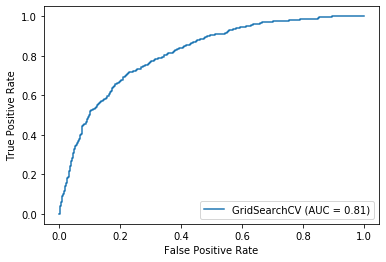

arrhythmia                   1.364216
atherosclero                 0.942269
ethnicity_unknown            0.679730
above_max 50912              0.351829
abn_percent 50885            0.340590
hypertension                 0.317243
diabetes                     0.311300
abn_percent 50912            0.296851
abn_percent 51006            0.282669
max 50912                    0.278597
ethnicity_other              0.252451
ethnicity_hispanic/latino    0.223460
above_max 51221              0.189044
above_max 51277              0.173373
above_max 51249              0.157782
gender                       0.153618
abn_percent 51222            0.153095
abn_percent 50868            0.138406
renal_failure                0.127505
min 50912                    0.120676
max 51277                    0.114238
below_min 51222              0.113904
below_min 50970              0.110992
min 51279                    0.110633
below_min 51006              0.102259
dtype: float64


In [19]:
results(grid_log)

# Model Refinement

In [ ]:
lasso
oversample
threshold

# Predict Future Diagnoses

Feasbility study to see if we can predict whether a patient will develop a disease (initially CHF) from their patient history leading up to (but not including) their first diagnosis. 

### Outline

1. Identify CHF patients
1. Look at patient histories
1. Look at co-morbidities
1. Identify first CHF diagnosis
1. Identify visit right before CHF diagnosis (< 1 mo)
1. Look for features to predict pre-CHF state (lab tests in history)

In [ ]:
################################
pos_codes = d_diagnoses[(d_diagnoses['long_title'].str.lower().str.contains('congestive',)) & (d_diagnoses['long_title'].str.lower().str.contains('heart'))]
pos_codes

In [ ]:
###############################
pos_diagnoses = diagnoses[diagnoses['icd_code'].isin(pos_codes.icd_code)]
admissions['pos_subj'] = np.where(admissions.subject_id.isin(pos_diagnoses.subject_id), 1, 0)
admissions['pos_adm'] = np.where(admissions.hadm_id.isin(pos_diagnoses.hadm_id), 1, 0)

admissions['admittime'] = pd.to_datetime(admissions.admittime)
admissions = admissions.sort_values('admittime')
admissions['dischtime'] = pd.to_datetime(admissions.dischtime)
admissions['hadm_time'] = admissions.dischtime - admissions.admittime

admissions = admissions.rename(columns={'hospital_expire_flag':'expire_flag'})

In [ ]:
primary_drg = drg_codes.drop('drg_code', axis=1).rename(columns={'description':'drg_code'})
primary_drg = primary_drg[['subject_id', 'hadm_id', 'drg_code']].drop_duplicates()
primary_drg = primary_drg.groupby('hadm_id').first().reset_index()
primary_drg.head()

In [ ]:
primary_icd = diagnoses[diagnoses['seq_num']==1].merge(d_diagnoses, how='left', on=['icd_version', 'icd_code'])
primary_icd = primary_icd.drop('icd_code', axis=1).rename(columns={'long_title':'icd_code'})
primary_icd = primary_icd[['subject_id', 'hadm_id', 'icd_code']].drop_duplicates()
primary_icd = primary_icd.groupby('hadm_id').first().reset_index()
primary_icd.head()

In [ ]:
admissions = admissions.merge(primary_drg, how='left').merge(primary_icd, how='left')
admissions.head()

In [ ]:
admissions.shape

# Move to EDA Notebook >>>>>>>>>>>>>>

In [ ]:
# General trends in CHF population

In [ ]:
admissions.groupby('ethnicity').agg({'pos_subj':['count', 'mean']})

In [ ]:
pos_index = admissions.groupby('subject_id').agg(pos_subj=('pos_subj', 'max'))
print(np.sum(pos_index))
print(np.mean(pos_index))

In [ ]:
result = admissions.groupby('pos_subj').agg(total_adm=('hadm_id','count'),
                                             adm_fraction=('hadm_id', lambda x: len(x)/524520),
                                             death_count=('expire_flag', 'sum'),
                                             death_fraction=('expire_flag', 'mean'))
result['chance_of_death'] = result.death_fraction/result.adm_fraction
# ^^^ DOUBLE CHECK THIS LINE FOR BAYSIAN PROBABILITY ^^^
result

In [ ]:
admissions.expire_flag.sum()/admissions.subject_id.nunique()

In [ ]:
admissions[admissions.pos_subj == 1].expire_flag.sum()/admissions[admissions.pos_subj == 1].subject_id.nunique()

In [ ]:
# how long on avg does it take for someone to die with CHF

# <<<<<<<<<<<<<<<<< MOVE TO EDA

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [ ]:
pd.set_option('display.width', 1000)

In [ ]:
rows = ['subject_id', 'admittime', 'pos_adm', 'expire_flag', 'drg_code', 'icd_code']
sample_adm = admissions[admissions.pos_subj==1][rows]
sample_adm['admittime'] = sample_adm.admittime.dt.date
for subj in sample_adm.sample(100).subject_id.unique():
    print('Subject: ', subj)
    print('-'*80)
    print(sample_adm[sample_adm.subject_id==subj][rows], '\n')

In [ ]:
#################################
# find patients who have a negative visit right before a positive visit

first_admissions = admissions.iloc[admissions[admissions.pos_subj==1].groupby('subject_id').admittime.idxmin()]
subj_list = first_admissions[first_admissions.pos_adm==0].subject_id.unique()

print('There are', admissions[admissions.pos_subj==1].subject_id.nunique(), 'subjects with CHF, and',
      len(subj_list), 'subjects with CHF that had at a negative visit before CHF diagnosis.')

In [ ]:
# create dataframes for first positive visits and most recent previous visits

# create refernce dataframe
subj_admissions = admissions[admissions.subject_id.isin(subj_list)]
subj_admissions = subj_admissions.sort_values(['subject_id', 'admittime']).reset_index(drop=True)
pos_adm = subj_admissions[['subject_id', 'hadm_id', 'admittime', 'pos_adm']]
pos_adm = pos_adm.loc[pos_adm[pos_adm.pos_adm==1].groupby('subject_id').admittime.idxmin()]
pos_adm = pos_adm.rename(columns={'pos_adm':'first_pos'}).drop('admittime', axis=1)
subj_admissions = subj_admissions.merge(pos_adm, how='left')

# slice based on first visit/prior visit
first_idx = subj_admissions[subj_admissions.first_pos==1].index
pos_adm = subj_admissions.iloc[first_idx].reset_index(drop=True)
pre_adm = subj_admissions.iloc[first_idx-1].reset_index(drop=True)

#sanity checks
print('Positive cases in previous visit: ', pre_adm.pos_adm.sum())
print('Mismatched patient count: ', np.sum(pos_adm['subject_id'] - pre_adm['subject_id']))

In [ ]:
pre_adm['time_delta'] = pos_adm.admittime - pre_adm.dischtime
pre_adm.time_delta.describe()

In [ ]:
pre_adm['time_delta'].apply(lambda x: x.days/365).hist(bins=10, range=(0,10))
plt.title('Time Delta for Patients Who Had \nOne Negative Visit Before Developing Heart Failure')
plt.xlabel('Years after Negative Visit')
plt.ylabel('Number of Patients')

In [ ]:
pre_adm['time_delta'].apply(lambda x: x.days/31).hist(bins=12, range=(0,12))
plt.title('Time Delta for Patients Who Had \nOne Negative Visit Before Developing Heart Failure')
plt.xlabel('Months after Negative Visit')
plt.ylabel('Number of Patients')

In [ ]:
# select group of interest (< 1 year before diagnosis)

pre_adm1 = pre_adm[pre_adm.time_delta < pd.to_timedelta('365 days')]
pre_adm1.head()

In [ ]:
#### RESERVED FOR LAB TESTS

# look for labs from visit right before CHF

# load lab tests
lab_events = pd.read_pickle("lab_events_final.pkl")
labs_adm1 = lab_events[lab_events.subject_id.isin(pre_adm1.subject_id)]
labs_adm1 = labs_adm1.merge(d_lab_events, how='left', on='itemid')
labs_adm1.subject_id.nunique()

###

In [ ]:
print('There are %i target patients who had one negative hospital visit within one year of heart failure.' % pre_adm1.shape[0])
print('On average, they had %i days before the diagnosis of heart failure.' % pre_adm1.time_delta.dt.days.mean())
print('For the lab tests, there are %i patients without any lab tests.' % (pre_adm1.shape[0] - labs_adm1.subject_id.nunique()))
print('For those with lab tests, there were %.1f tests run per patient.' % (labs_adm1.shape[0]/pre_adm1.shape[0]))

In [ ]:
pd.set_option('max_rows', 100) 
pd.set_option('min_rows', 100)        # display at least 100 rows when max is exceeded

# ARCHIVE >>>>>>>>>>>>>>>>>>

# Emergency EDA on Lab Tests

Outline:
1. Understand overall lab tests
1. Load all tests for CHF patients (subj_list)
1. Analyze most common tests for CHF

In [ ]:
# repeat setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = "D:\\Bootcamp\\MIMIC IV\\"
admissions = pd.read_csv(path + "core\\admissions.csv.gz", compression='gzip')
diagnoses = pd.read_csv(path + "hosp\\diagnoses_icd.csv.gz", compression='gzip')
d_diagnoses = pd.read_csv(path + "hosp\\d_icd_diagnoses.csv.gz", compression='gzip')
d_lab_events = pd.read_csv(path + "hosp\\d_labitems.csv.gz", compression='gzip')

###############################
pos_codes = d_diagnoses[(d_diagnoses['long_title'].str.lower().str.contains('congestive',)) & (d_diagnoses['long_title'].str.lower().str.contains('heart'))]
pos_diagnoses = diagnoses[diagnoses['icd_code'].isin(pos_codes.icd_code)]
admissions['pos_subj'] = np.where(admissions.subject_id.isin(pos_diagnoses.subject_id), 1, 0)
admissions['pos_adm'] = np.where(admissions.hadm_id.isin(pos_diagnoses.hadm_id), 1, 0)
admissions['admittime'] = pd.to_datetime(admissions.admittime)

###############################
first_hadm = admissions.iloc[admissions[admissions.pos_adm==1].groupby('subject_id').admittime.idxmin()]
hadm_list = first_hadm.hadm_id

In [ ]:
# look at overall lab events
d_lab_events.groupby(['fluid', 'category']).agg(total_count=('itemid',lambda x: len(np.unique(x)))).sort_values(by='total_count', ascending=False)

In [ ]:
%%time
# load *ALL* tests

chunksize = 3*(10 ** 6)
chunk = 1
cols_ = ['subject_id', 'hadm_id', 'specimen_id', 'itemid', 'value', 'valuenum', 'valueuom', \
         'ref_range_lower', 'ref_range_upper', 'priority', 'comments']
lab_events = []
for lab_chunk in pd.read_csv(path + "hosp\\labevents.csv.gz", compression='gzip', chunksize=chunksize):
    lab_chunk = lab_chunk[lab_chunk.hadm_id.isin(hadm_list)]
    lab_chunk = lab_chunk[cols_]
    lab_events.append(lab_chunk)
    print(f'Processed chunk: {chunk}')
    chunk += 1

# 5k patients
# 3min 52s

# 10k patients
# 4min 6s

# 15k patients
# 4min 27s


In [ ]:
lab_events = pd.concat(lab_events)

In [ ]:
lab_events.to_pickle("./lab_events.pkl")

In [ ]:
chf_labs = lab_events.merge(d_lab_events, how='left', on='itemid')
chf_labs = chf_labs.groupby(['itemid', 'label', 'fluid', 'category']).agg(freq=('subject_id', lambda x: len(np.unique(x))/chf_labs.subject_id.nunique()))\
.reset_index().sort_values('freq', ascending=False).head(40)

In [ ]:
chf_labs['freq'].reset_index(drop=True).plot(kind='line')
plt.xlabel('Top N Tests')
plt.ylabel('Percent')
plt.title('Percent of Heart Failure Patients Who\n Had The Top N Tests')

In [ ]:
print(chf_labs.reset_index(drop=True))

# <<<<<<<<<<<< ARCHIVE